In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False




In [28]:
import numpy as np
from scipy.spatial import cKDTree

## 산림 임상 데이터 불러오기

In [132]:
data = gpd.read_file("./modified_geopackage/merged100_converted.gpkg")
data = data.to_crs(epsg = 4326)
data["centroids"] = data.geometry.centroid
data

C:\Users\sc.lee\AppData\Local\Temp\ipykernel_21632\4169563870.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data["centroids"] = data.geometry.centroid


,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry,centroids
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ...",POINT (126.92202 37.44349)
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ...",POINT (126.91649 37.4881)
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ...",POINT (126.9229 37.49214)
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ...",POINT (126.91419 37.45243)
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ...",POINT (126.92328 37.45185)
...,...,...,...,...,...,...,...,...
262843,501718,Q,2,4,C,활엽수림,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ...",POINT (127.86934 35.9955)
262844,501719,Q,2,5,B,활엽수림,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35...",POINT (127.86485 35.99106)
262845,501720,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ...",POINT (127.8712 35.98653)
262846,501721,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9...",POINT (127.87439 35.99678)


## 기상 관측 지점 데이터 불러오기

In [150]:
loc_df = pd.read_csv("./meta-loc-edited.csv", encoding='cp949')
loc_gdf = gpd.GeoDataFrame(
    loc_df, geometry=gpd.points_from_xy(loc_df.경도, loc_df.위도), crs="EPSG:4326"
)
loc_gdf

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
3,144,1993-03-16,2011-12-09,군산(레),36.0123,126.7834,POINT (126.7834 36.0123)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


## 기상 관측 정보에 있는 지점들로 전처리 

In [ ]:
# 기상 관측 정보 불러오기 
weather = gpd.read_file("./whetherDataEH.csv", encoding='cp949')

In [ ]:
# 기상 관측 정보에 있는 지점들 찾기
loc_gdf_needed = loc_gdf[loc_gdf.지점명.isin(weather.지점명)]
loc_gdf_needed

# 관측 중단 후 시작된 지점 중복 데이터 제거됐는지 확인 (최신 관측소로 통일)

In [ ]:
# 지점 정보에 있는 중복 "지점명" 없음 
for i in loc_gdf_needed.지점명[loc_gdf_needed.지점명.duplicated() == True]:
    print(loc_gdf_needed[loc_gdf_needed.지점명 == i])

# weather data에서 빼야 할 강북*, 백아 발견 

In [ ]:
# 강북*, 백아 위치 정보 필요 
for i in weather.지점명.unique():
    if i not in loc_gdf_needed.지점명.unique():
        print(i)

강북*
백아


# 행정구역 경계 정보 불러오기 

In [19]:
bdd = gpd.read_file(f"./ctprvn/ctprvn.shp", encoding="euc-kr")
bdd.set_crs(epsg=5179, inplace=True)
bdd = bdd.to_crs(loc_gdf.crs)

### 3가지 동시에 plot

<Axes: >

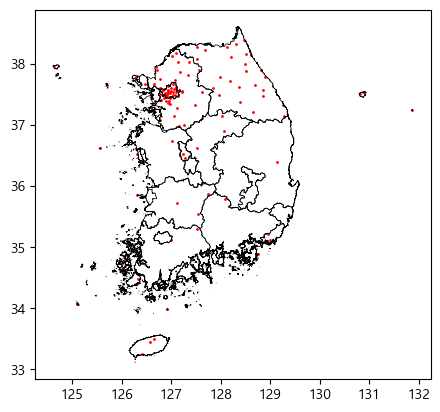

In [177]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)

<Axes: >

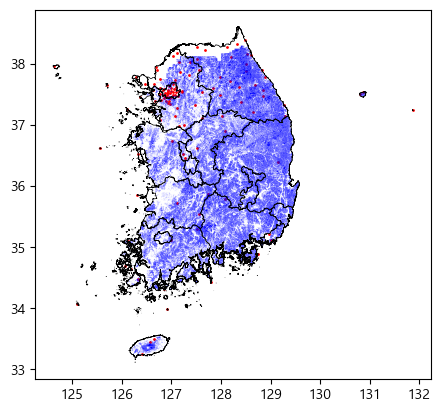

In [173]:
ax = loc_gdf_needed.plot(markersize=1, color= "red")
bdd.boundary.plot(ax = ax, color = "black", linewidth = 0.5)
data.plot(ax = ax, color= "blue", markersize= 0.3)

### Frst마다 nearest 관측 지점 mapping

In [ ]:
# frst polygon마다 중심점으로 변환 
centroids = gpd.GeoDataFrame(data[["index", "centroids"]], geometry="centroids", crs=data.crs)
centroids

,index,centroids
0,0,POINT (126.92202 37.44349)
1,1,POINT (126.91649 37.4881)
2,2,POINT (126.9229 37.49214)
3,3,POINT (126.91419 37.45243)
4,4,POINT (126.92328 37.45185)
...,...,...
262843,501718,POINT (127.86934 35.9955)
262844,501719,POINT (127.86485 35.99106)
262845,501720,POINT (127.8712 35.98653)
262846,501721,POINT (127.87439 35.99678)


In [175]:
any(centroids.index.duplicated())

False

In [185]:
# 가장 가까운 기상 관측 지점과 매핑 
nearest = gpd.sjoin_nearest(centroids, loc_gdf_needed[["geometry", "지점명"]], how="left", distance_col="distance")
nearest

c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,index,centroids,index_right,지점명,distance
0,0,POINT (126.92202 37.44349),118,관악,0.029679
1,1,POINT (126.91649 37.4881),74,기상청,0.005298
2,2,POINT (126.9229 37.49214),74,기상청,0.005523
3,3,POINT (126.91419 37.45243),81,금천,0.019143
4,4,POINT (126.92328 37.45185),81,금천,0.026817
...,...,...,...,...,...
262843,501718,POINT (127.86934 35.9955),24,설천봉,0.180706
262844,501719,POINT (127.86485 35.99106),24,설천봉,0.174395
262845,501720,POINT (127.8712 35.98653),24,설천봉,0.175755
262846,501721,POINT (127.87439 35.99678),24,설천봉,0.185171


In [ ]:
# 각 지점으로부터 distance 분포 체크
nearest["distance"].describe()

count    262848.000000
mean          0.265996
std           0.154348
min           0.000470
25%           0.136994
50%           0.245743
75%           0.380964
max           0.734460
Name: distance, dtype: float64

<Axes: xlabel='distance'>

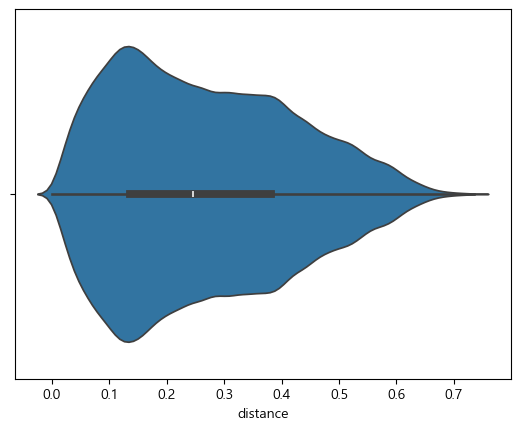

In [ ]:
# max값인 0.7은 대략 70km가 넘는 거리 ...... 다른 기상 데이터..?
sns.violinplot(x=nearest["distance"])

### Merging Weather Observing Location with Forest Data

In [187]:
full_data = data.merge(centroids, on = "index", how = "left")
full_data

,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry,centroids_x,centroids_y
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92156 37.44277, 126.92144 ...",POINT (126.92202 37.44349),POINT (126.92202 37.44349)
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.91631 37.48976, 126.91672 ...",POINT (126.91649 37.4881),POINT (126.91649 37.4881)
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((126.92213 37.49274, 126.92385 ...",POINT (126.9229 37.49214),POINT (126.9229 37.49214)
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.91117 37.45484, 126.91303 ...",POINT (126.91419 37.45243),POINT (126.91419 37.45243)
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((126.92227 37.45497, 126.92483 ...",POINT (126.92328 37.45185),POINT (126.92328 37.45185)
...,...,...,...,...,...,...,...,...,...
262843,501718,Q,2,4,C,활엽수림,"MULTIPOLYGON (((127.86824 35.99774, 127.87158 ...",POINT (127.86934 35.9955),POINT (127.86934 35.9955)
262844,501719,Q,2,5,B,활엽수림,"MULTIPOLYGON (((127.8648 35.99199, 127.8671 35...",POINT (127.86485 35.99106),POINT (127.86485 35.99106)
262845,501720,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.87263 35.98754, 127.87137 ...",POINT (127.8712 35.98653),POINT (127.8712 35.98653)
262846,501721,Q,2,5,C,활엽수림,"MULTIPOLYGON (((127.875 35.99708, 127.875 35.9...",POINT (127.87439 35.99678),POINT (127.87439 35.99678)
